In [1]:
import os
import numpy as np
from gwpy.timeseries import TimeSeries, TimeSeriesDict
import matplotlib.pyplot as plt

/home/x-ctirapongpra/.local/lib/python3.9/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


Time: 0.0000 to 24.0000 seconds
Sample rate: 10000.0 Hz
Duration: 24.000 seconds


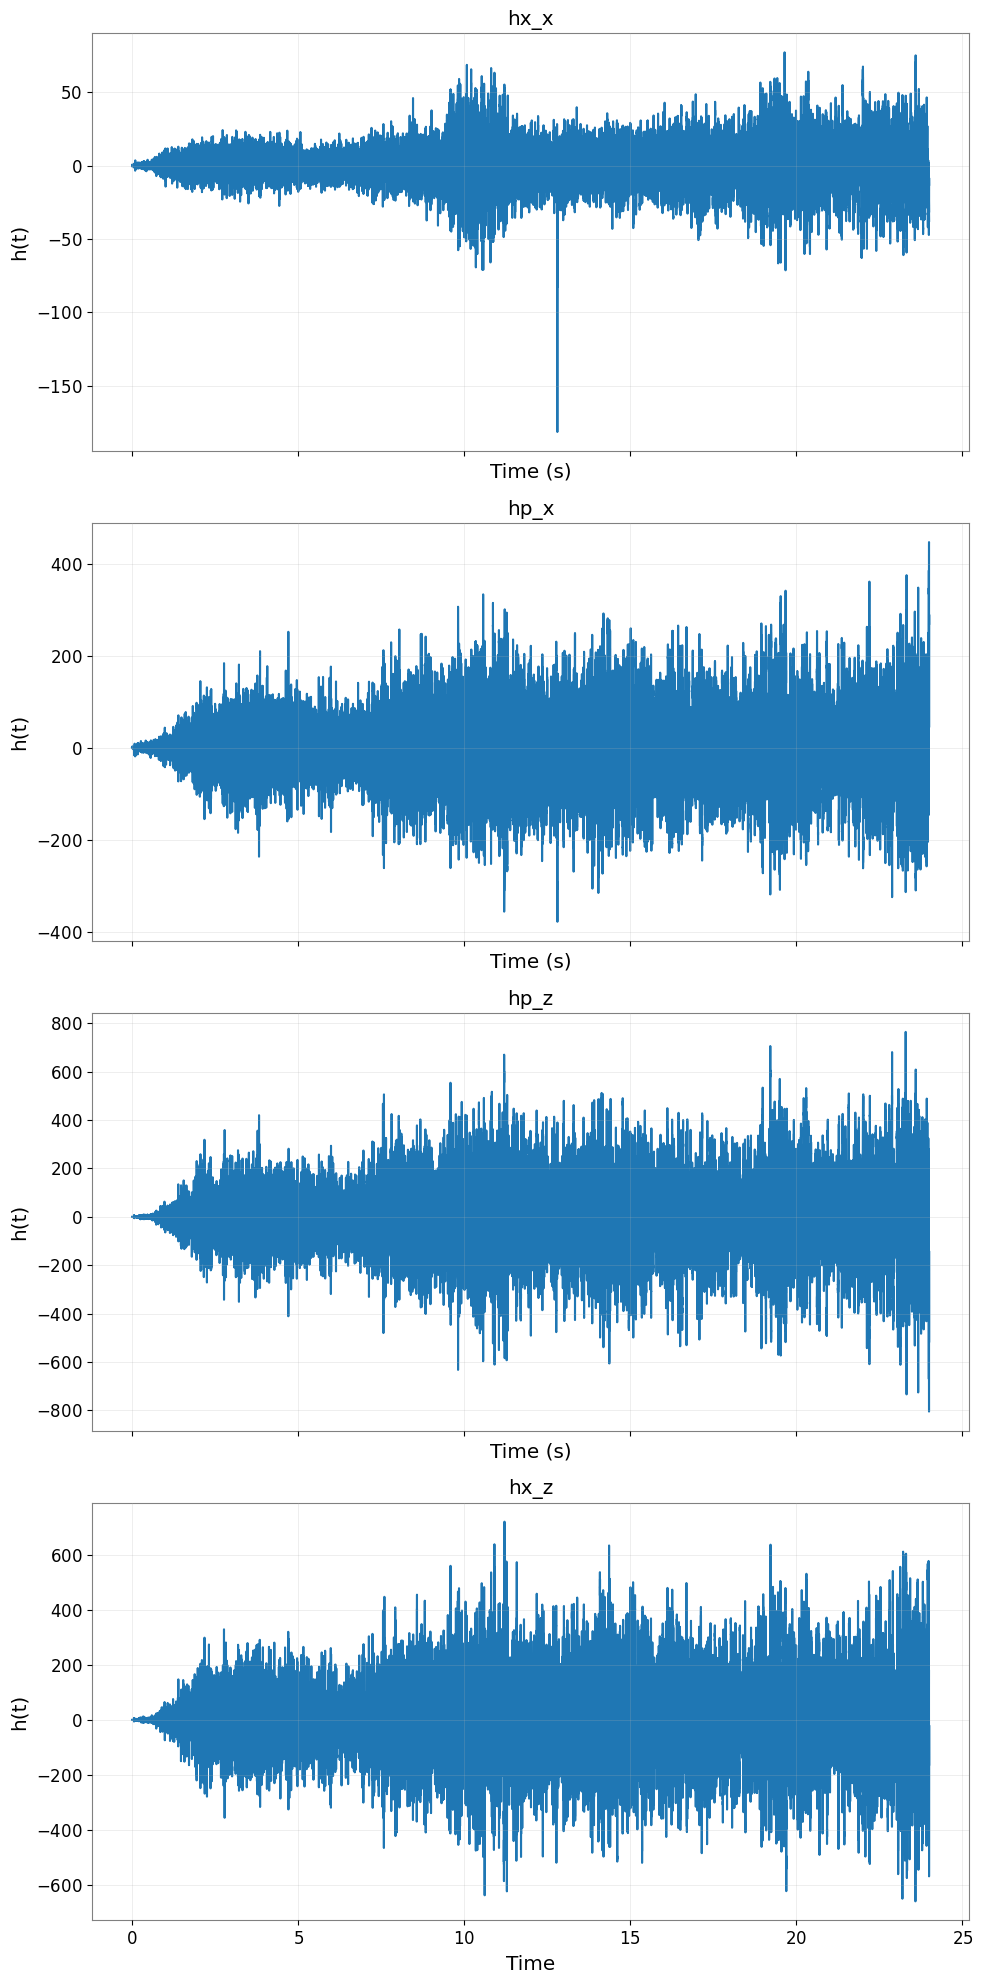

In [2]:
# Configuration
data_dir = 'h(t)'
output_gwf = 'Frame.gwf'
t0_gps = 1000000000  # GPS start time (arbitrary)

# Load time data
time_data = np.loadtxt(os.path.join(data_dir, 't.txt'), delimiter=',') # (comma-separated)

print(f"Time: {time_data[0]:.4f} to {time_data[-1]:.4f} seconds")

# Calculate sample rate
dt = time_data[1] - time_data[0]
sample_rate = 1.0 / dt

print(f"Sample rate: {sample_rate:.1f} Hz")
print(f"Duration: {time_data[-1] - time_data[0]:.3f} seconds")

# Plot the models
model_files = [f for f in os.listdir(data_dir) if f != 't.txt']

fig, axs = plt.subplots(4, 1, figsize=(10, 20), sharex=True)
for i, model_file in enumerate(model_files[:4]):
    file_path = os.path.join(data_dir, model_file)
    h = np.loadtxt(file_path, delimiter=',')
    axs[i].plot(time_data, h)
    axs[i].set_title(model_file.replace('.txt', ''))
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('h(t)')
    axs[i].grid(True, alpha=0.3)

axs[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

In [3]:
# Define the 4 channels
channels = {
    'GW:HP_X': 'hp_x.txt',  # h-plus polarization, X viewing angle
    'GW:HP_Z': 'hp_z.txt',  # h-plus polarization, Z viewing angle
    'GW:HX_X': 'hx_x.txt',  # h-cross polarization, X viewing angle
    'GW:HX_Z': 'hx_z.txt',  # h-cross polarization, Z viewing angle
}

timeseries_dict = {}

for channel_name, filename in channels.items():
    filepath = os.path.join(data_dir, filename)
    print(f"Loading {channel_name} from {filename}...")
    
    # Load data (newline-separated)
    data = np.loadtxt(filepath)
    print(f"Data range: [{data.min():.6e}, {data.max():.6e}]")
    
    # Create TimeSeries object
    ts = TimeSeries(
        data,
        sample_rate=sample_rate,
        t0=t0_gps,
        name=channel_name,
        unit='strain'
    )
    
    timeseries_dict[channel_name] = ts

# Write to GWF file
ts_write = TimeSeriesDict(timeseries_dict)
ts_write.write(output_gwf, format='gwf')

# Sanity check by reading back
ts_read = TimeSeriesDict.read(output_gwf, list(channels.keys()), format='gwf')

for ch in channels.keys():
    if ch in ts_read:
        data_matches = np.allclose(timeseries_dict[ch].value, ts_read[ch].value)
        assert data_matches, f"Data mismatch for channel {ch}"

Loading GW:HP_X from hp_x.txt...
Data range: [-3.786800e+02, 4.479800e+02]
Loading GW:HP_Z from hp_z.txt...
Data range: [-8.056900e+02, 7.651100e+02]
Loading GW:HX_X from hx_x.txt...
Data range: [-1.816600e+02, 7.721900e+01]
Loading GW:HX_Z from hx_z.txt...
Data range: [-6.592400e+02, 7.195400e+02]


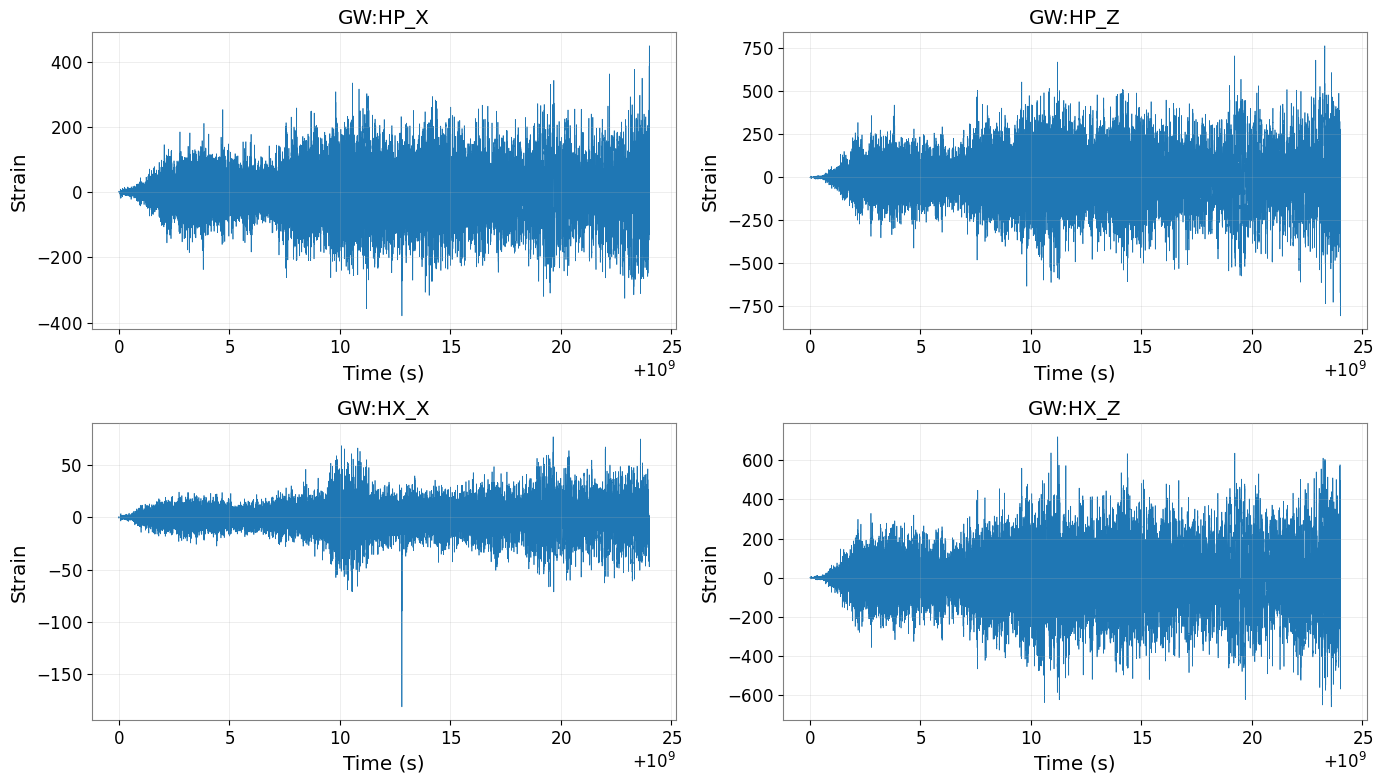

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, (channel_name, ts) in enumerate(timeseries_dict.items()):
    ax = axes[i]
    ax.plot(ts.times.value, ts.value, linewidth=0.5)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Strain')
    ax.set_title(channel_name)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()